In [98]:
import pandas as pd
import numpy as np
import math
from itertools import cycle
import statistics

#from datetime import datetime
import datetime

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

from scipy.stats import randint
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
import scikitplot as skplt
import sklearn as sk
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as ltb
import xgboost as xgb

import statsmodels.api as sm
import statsmodels
from statsmodels.tools import eval_measures

from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from fredapi import Fred
import pandas_datareader as pdr

import warnings

In [99]:
sk.set_config(display='diagram')
warnings.filterwarnings("ignore")
shap.initjs()

# Plotting using Seaborn
sns.set(style="whitegrid")
style.use("seaborn-white")

In [100]:
fred = Fred(api_key='c0a3f23bdd23a65e6546b6d0e5f4d4a5')

In [101]:
from common.load_features import get_recession, add_recession_feature, get_fed_chair, add_fed_chair
from common.load_data import load_taylor,load_taylor2, load_taylor1a,load_misery, time_split
from common.calc_metrics import model_results

# Setup

## variables

In [102]:
rand_int = 12

#  Set start date
start_date = datetime.date(1940, 1, 1)
start_date_str = datetime.datetime.strftime(start_date, "%Y-%m-%d")

#  Federal Reserve Economic Data Service
data_source = 'fred'

# Functions

In [103]:
# Function to highlight maximum values in each column
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]


In [104]:
t0_df = load_taylor()
train0_df, test0_df = time_split(t0_df)

model_stats_df = model_results('ffef_tr_test', train0_df['FEDFUNDS'], train0_df['ffef_tr'], train0_df.shape[0], 2  , None )
model_stats_df = model_results('ffef_tr_test', test0_df['FEDFUNDS'], test0_df['ffef_tr'], test0_df.shape[0], 2  , model_stats_df )

model_stats_df = model_results('ffef_tr2_test', train0_df['FEDFUNDS'], train0_df['ffef_tr2'], train0_df.shape[0], 2  , model_stats_df )
model_stats_df = model_results('ffef_tr2_test', test0_df['FEDFUNDS'], test0_df['ffef_tr2'], test0_df.shape[0], 2  , model_stats_df )

model_stats_df = model_results('Naive_test', train0_df['FEDFUNDS'], train0_df['FEDFUNDS-1'], train0_df.shape[0], 1  , model_stats_df )
model_stats_df = model_results('Naive_test', test0_df['FEDFUNDS'], test0_df['FEDFUNDS-1'], test0_df.shape[0], 1  , model_stats_df )

model_stats_df.round(2)

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
holston_df: (250, 4)
train_df:  (200, 18)
test_df:  (50, 18)


,name,r_sq,adj_r_sq,mse,rmse
0,ffef_tr_test,-0.96,-0.97,22.84,4.78
1,ffef_tr_test,-39.03,-39.86,54.77,7.40
2,ffef_tr2_test,0.45,0.44,6.47,2.54
3,ffef_tr2_test,-13.42,-13.72,19.73,4.44
4,Naive_test,0.92,0.92,0.93,0.96
5,Naive_test,0.88,0.88,0.16,0.40


# Explore

In [105]:
t_df = load_taylor()
m_df = load_misery()
r_df = get_recession()
r_df = r_df.query('Peak_Date >= "1960-01-01"')
chair_df = get_fed_chair()

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
holston_df: (250, 4)
t_df: (832, 3)
u_df: (909, 1)
misery_df: (831, 5)


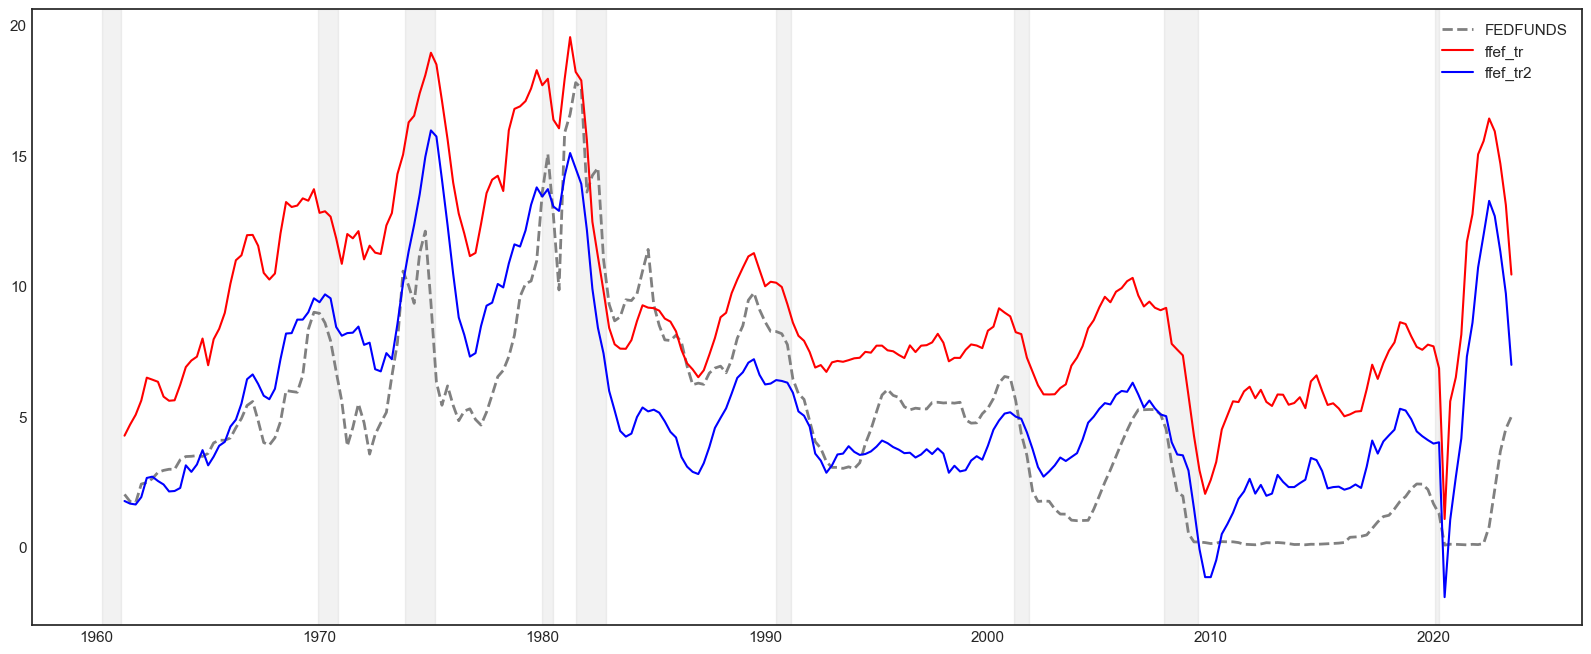

In [107]:
cycol = cycle('rgbcmyk')
min_value = t_df[['FEDFUNDS','gap_ue','ffef_tr']].values.min()

# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(t_df.index, t_df['FEDFUNDS'], linestyle='--', color='gray',linewidth=2)
ax.plot(t_df.index, t_df['ffef_tr'], color='red',linewidth=1.5)
ax.plot(t_df.index, t_df['ffef_tr2'], color='blue',linewidth=1.5)

# Plotting recession bars
for i,row in r_df.iterrows():
    plt.axvspan(row['Peak_Date'], row['Trough_Date'], color='gray', alpha=0.1)
       
ax.legend(["FEDFUNDS","ffef_tr",'ffef_tr2'])
#plt.legend()
plt.grid(False)
plt.show()

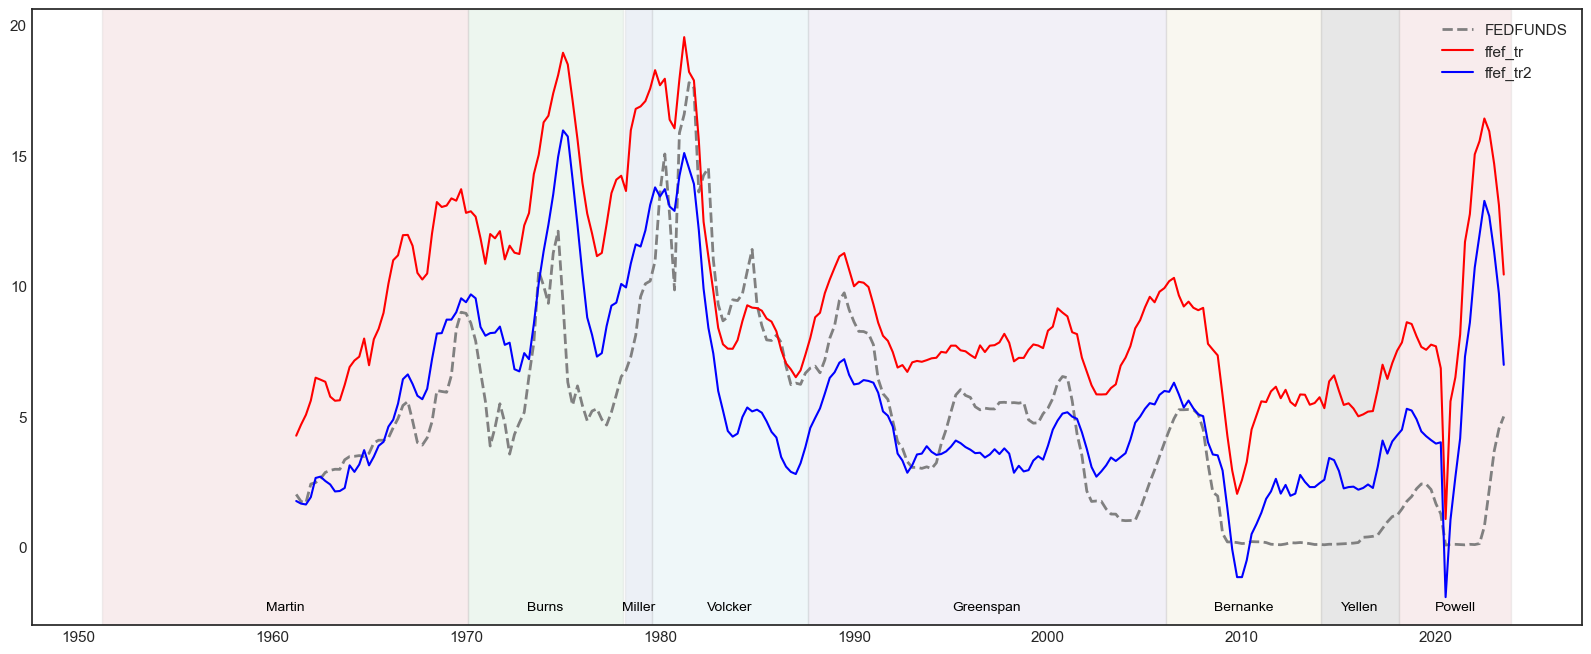

In [108]:
cycol = cycle('rgbcmyk')
min_value = t_df[['FEDFUNDS','ffef_tr','ffef_tr2']].values.min() - 0.5


# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(t_df.index, t_df['FEDFUNDS'], linestyle='--', color='gray',linewidth=2)
ax.plot(t_df.index, t_df['ffef_tr'], color='red',linewidth=1.5)
ax.plot(t_df.index, t_df['ffef_tr2'], color='blue',linewidth=1.5)
    
    
# Plotting recession bars
for i,row in chair_df.query('End_Date >= "1960-01-01"').iterrows():
    plt.axvspan(row['Start_Date'], row['End_Date'], facecolor=next(cycol), edgecolor='gray', alpha=0.1, label=row['Name'])
    midpoint = row['Start_Date'] + (row['End_Date'] - row['Start_Date']) / 2
    plt.text(midpoint, min_value, row['Name'],fontsize=10, color='black', ha='center')
    
    
ax.legend(["FEDFUNDS","ffef_tr",'ffef_tr2'])
#plt.legend()
plt.grid(False)
plt.show()

# Taylor Rule

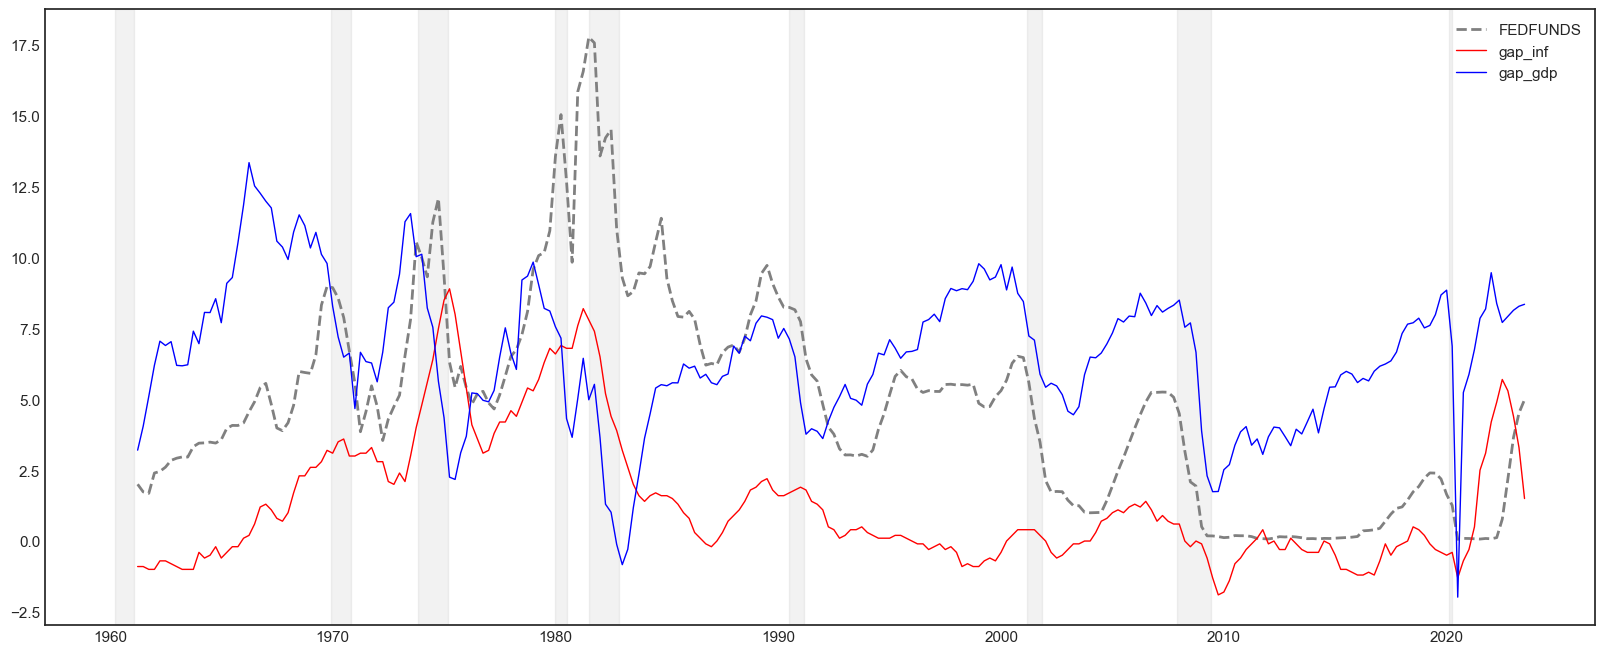

In [109]:
cycol = cycle('rgbcmyk')
min_value = t_df[['FEDFUNDS','gap_ue','ffef_tr']].values.min()

# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(t_df.index, t_df['FEDFUNDS'], linestyle='--', color='gray',linewidth=2)
ax.plot(t_df.index, t_df['gap_inf'], color='red',linewidth=1)
ax.plot(t_df.index, t_df['gap_gdp'], color='blue',linewidth=1)

# Plotting recession bars
for i,row in r_df.iterrows():
    plt.axvspan(row['Peak_Date'], row['Trough_Date'], color='gray', alpha=0.1)
       
ax.legend(["FEDFUNDS","gap_inf",'gap_gdp'])
#plt.legend()
plt.grid(False)
plt.show()

# Modified Taylor Rule

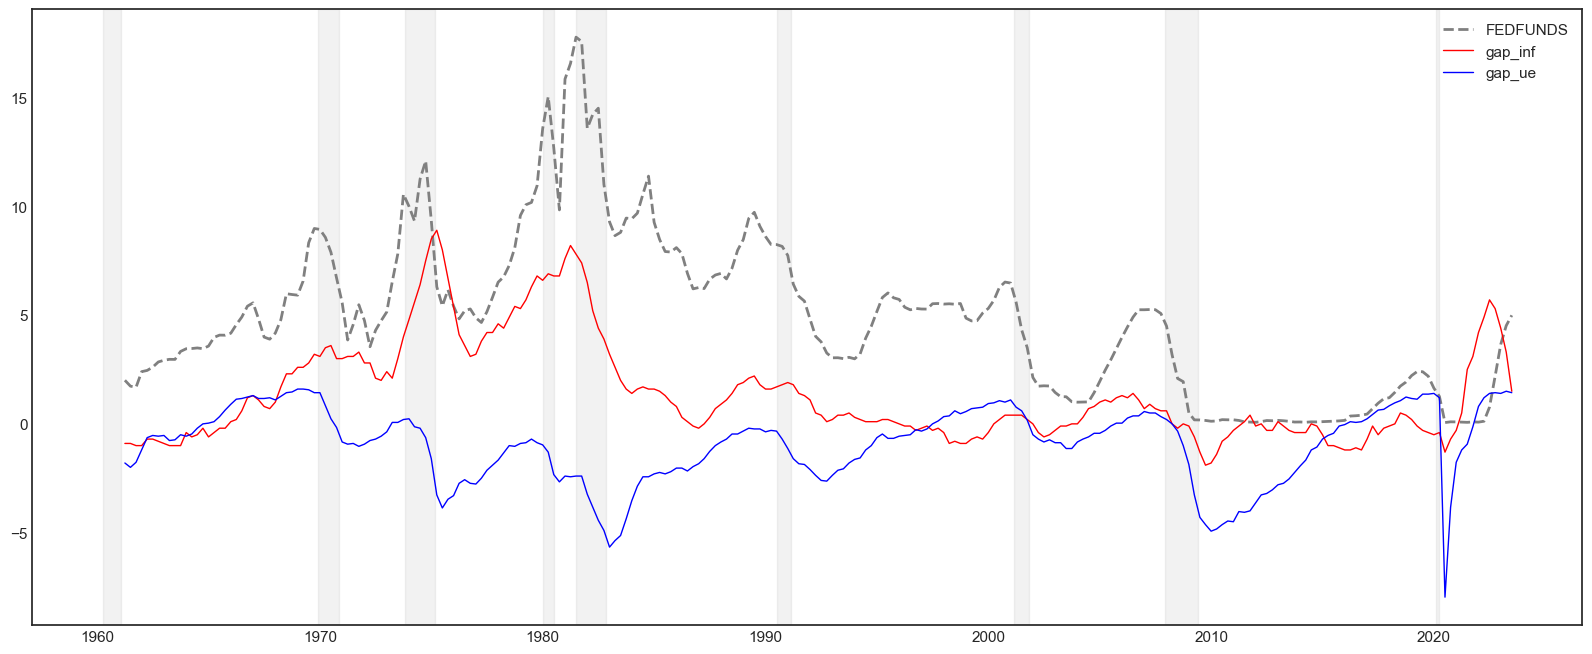

In [110]:
cycol = cycle('rgbcmyk')
min_value = t_df[['FEDFUNDS','gap_ue','ffef_tr']].values.min()

# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(t_df.index, t_df['FEDFUNDS'], linestyle='--', color='gray',linewidth=2)
ax.plot(t_df.index, t_df['gap_inf'], color='red',linewidth=1)
ax.plot(t_df.index, t_df['gap_ue'], color='blue',linewidth=1)

# Plotting recession bars
for i,row in r_df.iterrows():
    plt.axvspan(row['Peak_Date'], row['Trough_Date'], color='gray', alpha=0.1)
       
ax.legend(["FEDFUNDS","gap_inf",'gap_ue'])
#plt.legend()
plt.grid(False)
plt.show()

train0_df['chair_name']

#train0_df['FEDFUNDS'][train0_df['chair_name']=='Burns']
train0_df['ffef_tr'][train0_df['chair_name']=='Burns']

In [116]:
model_stats_df = None

In [117]:
for i, row in chair_df.iterrows():
    print('---', row['Name'], '---')
    try:
        model_stats_df = model_results(f'Modified Taylor - Train_{row["Name"]}', train0_df['FEDFUNDS'][train0_df['chair_name']==row['Name']], train0_df['ffef_tr'][train0_df['chair_name']==row['Name']], train0_df.shape[0], 1  , model_stats_df )
        model_stats_df = model_results(f'ModifiedT aylor - Test_{row["Name"]}', test0_df['FEDFUNDS'][test0_df['chair_name']==row['Name']], test0_df['ffef_tr'][test0_df['chair_name']==row['Name']], test0_df.shape[0], 1  , model_stats_df )
    except Exception as e:
        print(f"An error occurred: {e}")
        
        
for i in t_df['recession_flag'].unique():
    print('---', i , '---')
    try:
        model_stats_df = model_results(f'Taylor - Train_Reccession - {i}', train0_df['FEDFUNDS'][train0_df['recession_flag']==i], train0_df['ffef_tr'][train0_df['recession_flag']==i], train0_df.shape[0], 1  , model_stats_df )
        model_stats_df = model_results(f'Taylor - Test_Reccession - {i}', test0_df['FEDFUNDS'][test0_df['recession_flag']==i], test0_df['ffef_tr'][test0_df['recession_flag']==i], test0_df.shape[0], 1  , model_stats_df )
    except Exception as e:
        print(f"An error occurred: {e}") 

--- McCabe ---
An error occurred: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
--- Martin ---
An error occurred: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
--- Burns ---
An error occurred: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
--- Miller ---
An error occurred: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
--- Volcker ---
An error occurred: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
--- Greenspan ---
An error occurred: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
--- Bernanke ---
--- Yellen ---
An error occurred: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
--- Powell ---
An error occurred: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
--- False ---
--- True ---


In [118]:
for i, row in chair_df.iterrows():
    print('---', row['Name'], '---')
    try:
        model_stats_df = model_results(f'Modified Taylor - Train_{row["Name"]}', train0_df['FEDFUNDS'][train0_df['chair_name']==row['Name']], train0_df['ffef_tr2'][train0_df['chair_name']==row['Name']], train0_df.shape[0], 1  , model_stats_df )
        model_stats_df = model_results(f'ModifiedT aylor - Test_{row["Name"]}', test0_df['FEDFUNDS'][test0_df['chair_name']==row['Name']], test0_df['ffef_tr2'][test0_df['chair_name']==row['Name']], test0_df.shape[0], 1  , model_stats_df )
    except Exception as e:
        print(f"An error occurred: {e}")
        
        
for i in t_df['recession_flag'].unique():
    print('---', i , '---')
    try:
        model_stats_df = model_results(f'Taylor - Train_Reccession - {i}', train0_df['FEDFUNDS'][train0_df['recession_flag']==i], train0_df['ffef_tr2'][train0_df['recession_flag']==i], train0_df.shape[0], 1  , model_stats_df )
        model_stats_df = model_results(f'Taylor - Test_Reccession - {i}', test0_df['FEDFUNDS'][test0_df['recession_flag']==i], test0_df['ffef_tr2'][test0_df['recession_flag']==i], test0_df.shape[0], 1  , model_stats_df )
    except Exception as e:
        print(f"An error occurred: {e}") 

--- McCabe ---
An error occurred: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
--- Martin ---
An error occurred: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
--- Burns ---
An error occurred: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
--- Miller ---
An error occurred: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
--- Volcker ---
An error occurred: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
--- Greenspan ---
An error occurred: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
--- Bernanke ---
--- Yellen ---
An error occurred: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
--- Powell ---
An error occurred: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
--- False ---
--- True ---


In [119]:
model_stats_df.round(2)

,name,r_sq,adj_r_sq,mse,rmse
0,Modified Taylor - Train_Martin,-6.78,-6.78,25.43,5.04
1,Modified Taylor - Train_Burns,-10.08,-10.08,54.55,7.39
2,Modified Taylor - Train_Miller,-31.22,-31.22,59.02,7.68
3,Modified Taylor - Train_Volcker,0.50,0.50,5.73,2.39
4,Modified Taylor - Train_Greenspan,-1.64,-1.64,13.25,3.64
5,Modified Taylor - Train_Bernanke,-2.93,-2.93,19.42,4.41
6,ModifiedT aylor - Test_Bernanke,-31494.59,-31494.59,31.41,5.60
7,Taylor - Train_Reccession - False,-1.57,-1.57,23.12,4.81
8,Taylor - Test_Reccession - False,-38.68,-38.68,55.25,7.43
9,Taylor - Train_Reccession - True,0.03,0.03,21.00,4.58
